In [1]:
import requests
import os
import zipfile
import pandas as pd
import re
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, TruncatedSVD

# Baixando arquivos

In [2]:
url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
url2 = "https://files.grouplens.org/datasets/movielens/ml-1m-README.txt"
local_filename = "ml-1m.zip"
local_readme = "ml-1m-README.txt"

In [3]:
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [4]:
with requests.get(url2, stream=True) as response:
    response.raise_for_status()
    with open(local_readme, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [5]:
extract_dir = os.path.dirname(os.path.abspath(local_filename))

In [6]:
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Manipulação de dados

In [2]:
file_path1 = "ml-1m/ratings.dat"
file_path2 = "ml-1m/movies.dat"

In [3]:
ratings = pd.read_csv(file_path1, sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
movies = pd.read_csv(file_path2, sep='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')

In [5]:
movies['Genres'] = movies['Genres'].str.replace('|', ',')

In [6]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),"Animation,Children's,Comedy"
1,2,Jumanji (1995),"Adventure,Children's,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama"
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies['Year'] = movies['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)

In [8]:
null_counts = movies.isnull().sum()
null_counts

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64

In [9]:
null_counts = ratings.isnull().sum()
null_counts

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [10]:
num_users = ratings['UserID'].nunique()
num_users

6040

In [11]:
num_movies = movies['MovieID'].nunique()
num_movies

3883

In [17]:
df_genres = movies.copy()
df_genres = df_genres.drop('Genres', axis=1).join(movies['Genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Genre'))

/home/savio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


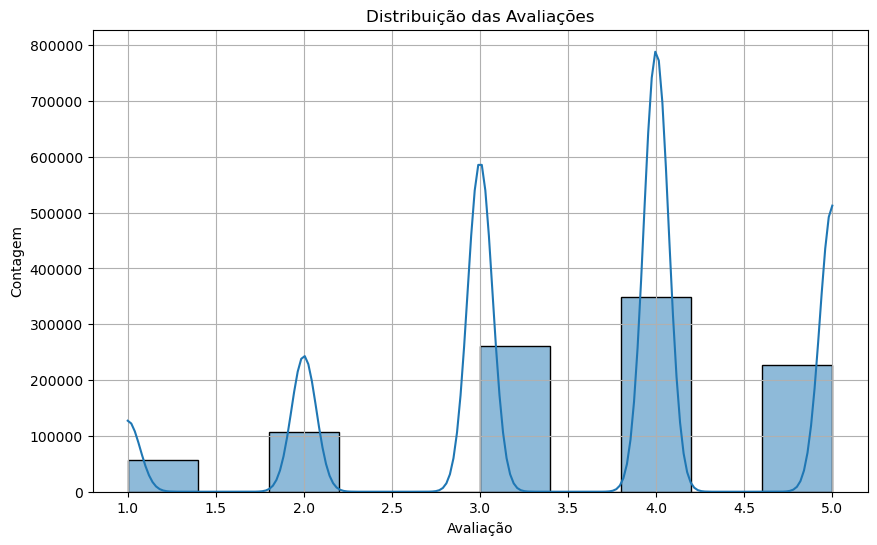

In [18]:
# 1. Distribuição das Avaliações
plt.figure(figsize=(10, 6))
sns.histplot(ratings['Rating'], bins=10, kde=True)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

Podemos ver a grande concentração de notas em 4 estrelas.

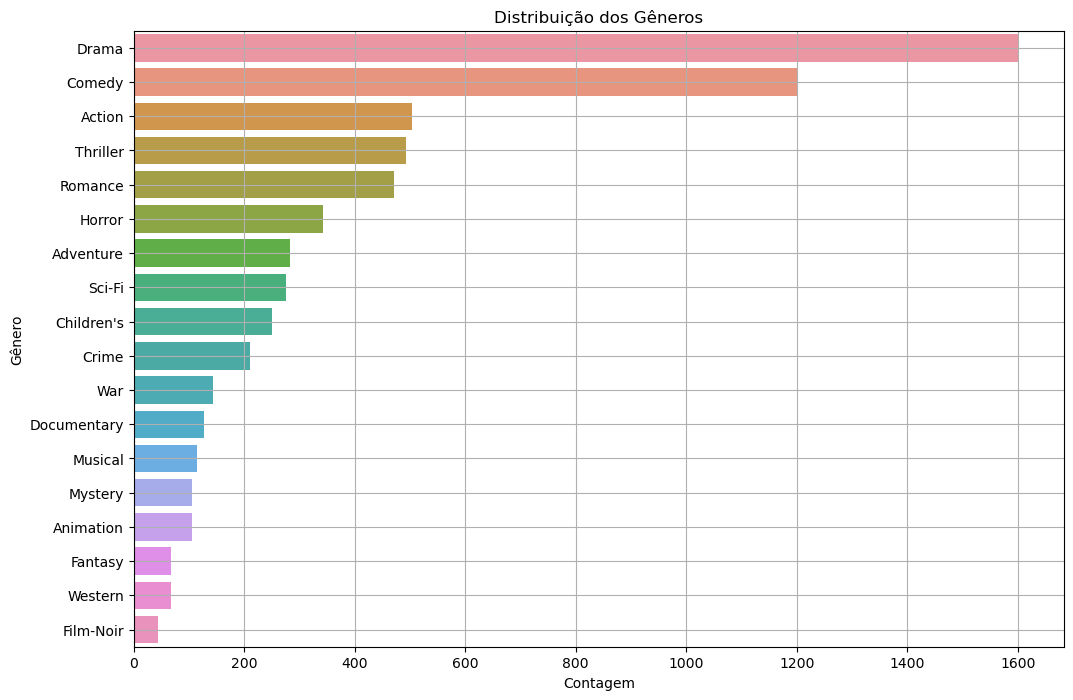

In [19]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Genre', data=df_genres, order = df_genres['Genre'].value_counts().index)
plt.title('Distribuição dos Gêneros')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.grid(True)
plt.show()

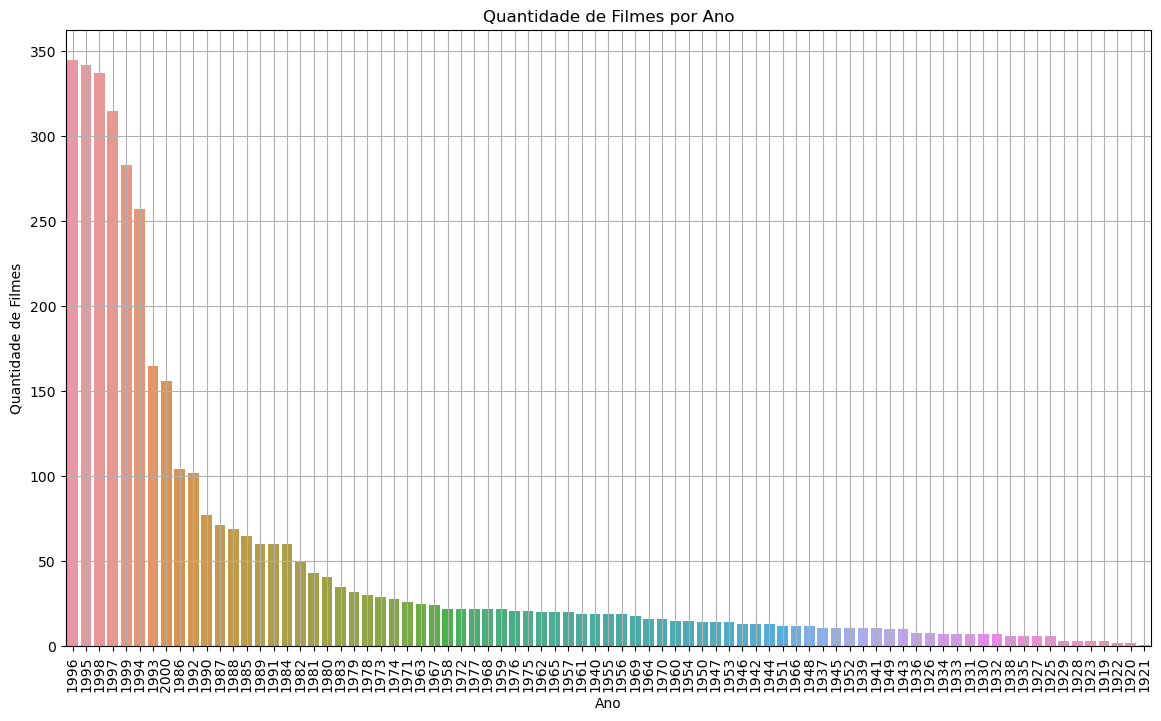

In [20]:
plt.figure(figsize=(14, 8))
sns.countplot(x='Year', data=movies, order = movies['Year'].value_counts().index)
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Pré-processamento dos dados:

In [12]:
duplicated_ratings = ratings[ratings.duplicated()]

In [13]:
if not duplicated_ratings.empty:
    print("Valores duplicados encontrados:")
    print(duplicated_ratings)
else:
    print("Não há valores duplicados nas avaliações.")

Não há valores duplicados nas avaliações.


Existem filmes que não foram classificados.

In [14]:
movies_in_ratings = movies[movies['MovieID'].isin(ratings['MovieID'])].copy()

In [15]:
movies_in_ratings['MovieIDTrue'] = range(1, len(movies_in_ratings) + 1)

In [16]:
ratings = ratings.merge(movies_in_ratings[['MovieID', 'MovieIDTrue']], on='MovieID', how='left')

In [17]:
num_movies = movies_in_ratings['MovieIDTrue'].nunique()
num_movies

3706

Criando a matriz de classificação, onde as linhas são os filmes e colunas as avaliações

In [18]:
ratings_matrix = np.empty((num_movies, num_users))

In [19]:
ratings_matrix[:] = np.nan

In [20]:
for index, row in ratings.iterrows():
    ratings_matrix[row['MovieIDTrue']-1][row['UserID']-1] = row['Rating']

In [21]:
ratings_matrix

array([[ 5., nan, nan, ..., nan, nan,  3.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Substituiremos os valores vazios com a média, de modo que ao aplicar o StandardScaler, esses valores sejam iguais a zero.

In [22]:
def replace_nans_with_row_mean(matrix):
    for i in range(matrix.shape[0]):
        row = matrix[i, :]
        mean_value = np.nanmean(row)
        row[np.isnan(row)] = mean_value
    return matrix

In [23]:
ratings_matrix = replace_nans_with_row_mean(ratings_matrix)

In [24]:
ratings_matrix

array([[5.        , 4.14684641, 4.14684641, ..., 4.14684641, 4.14684641,
        3.        ],
       [3.20114123, 3.20114123, 3.20114123, ..., 3.20114123, 3.20114123,
        3.20114123],
       [3.0167364 , 3.0167364 , 3.0167364 , ..., 3.0167364 , 3.0167364 ,
        3.0167364 ],
       ...,
       [3.66666667, 3.66666667, 3.66666667, ..., 3.66666667, 3.66666667,
        3.66666667],
       [3.9       , 3.9       , 3.9       , ..., 3.9       , 3.9       ,
        3.9       ],
       [3.78092784, 3.78092784, 3.78092784, ..., 3.78092784, 3.78092784,
        3.78092784]])

Aparentemente, alguns filmes tiveram a mesma nota para todos os avaliadores, fazendo com que o desvio padrão seja 0. Por escolha irei atribuir um valor nulo nesses casos.

In [25]:
def normalize_row(row):
    mean = np.mean(row)
    std = np.std(row)
    mean = np.nanmean(row)
    std = np.nanstd(row)
    if std == 0:
        return np.zeros_like(row)  # Substituir por zeros se o desvio padrão for zero
    return (row - mean) / std
    return (row - mean) / std

In [26]:
ratings_matrix_normalized = np.apply_along_axis(normalize_row, 1, ratings_matrix)

In [27]:
total_nans = np.isnan(ratings_matrix_normalized).sum()
print(f"Número total de NaNs: {total_nans}")

Número total de NaNs: 0


In [28]:
ratings_matrix_normalized

array([[ 1.70731838e+00,  1.77740956e-15,  1.77740956e-15, ...,
         1.77740956e-15,  1.77740956e-15, -2.29505214e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.53184131e-15,  4.53184131e-15,  4.53184131e-15, ...,
         4.53184131e-15,  4.53184131e-15,  4.53184131e-15],
       [ 5.22691510e-15,  5.22691510e-15,  5.22691510e-15, ...,
         5.22691510e-15,  5.22691510e-15,  5.22691510e-15],
       [ 5.62870295e-15,  5.62870295e-15,  5.62870295e-15, ...,
         5.62870295e-15,  5.62870295e-15,  5.62870295e-15]])

# Matriz de distâncias

Calculando a matriz de distância para uso com os métodos de DBScan e Cluster Hierárquico

In [29]:
dist_matrix = pdist(ratings_matrix_normalized, metric='euclidean')

In [30]:
dist_matrix_square = squareform(dist_matrix)

In [31]:
dist_matrix_square

array([[  0.        , 105.69494673, 107.3649446 , ..., 109.17594079,
        109.26922304, 108.33532832],
       [105.69494673,   0.        , 107.94088516, ..., 110.57554306,
        110.26061826, 109.60542063],
       [107.3649446 , 107.94088516,   0.        , ..., 108.46084939,
        108.92857814, 109.09574796],
       ...,
       [109.17594079, 110.57554306, 108.46084939, ...,   0.        ,
        107.70125075, 106.18090639],
       [109.26922304, 110.26061826, 108.92857814, ..., 107.70125075,
          0.        , 103.6646929 ],
       [108.33532832, 109.60542063, 109.09574796, ..., 106.18090639,
        103.6646929 ,   0.        ]])

# Kmeans

Vamos utilizar o método do Knee point para obetr uma estimativa inicial do valor de K

In [32]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42}

In [33]:
sse = []
for k in range(1, 81):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs, )
   kmeans.fit(ratings_matrix_normalized)
   sse.append(kmeans.inertia_)

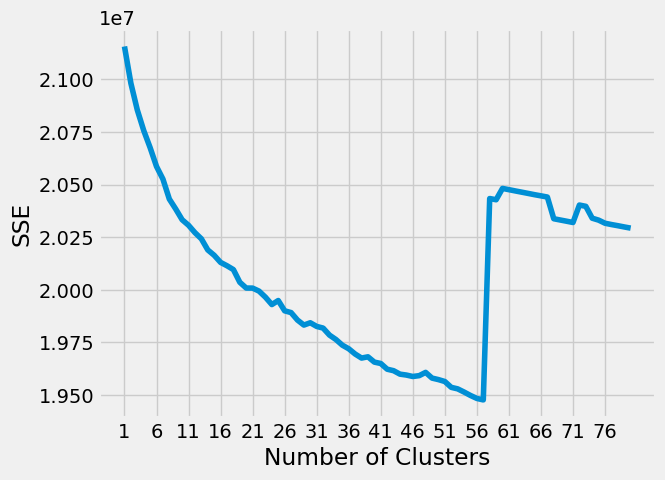

In [34]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 81), sse)
plt.xticks(range(1, 81, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [35]:
kl = KneeLocator(range(1, 81), sse, curve="convex", direction="decreasing")

In [36]:
kl.elbow

20

Verificou-se um ponto de cotovelo por volta de 20, mas 20 em si deu resultados bem ruins na clusterização, então aproximei por 21

In [37]:
kmeans = KMeans(n_clusters=21, random_state=42, n_init = 10)
kmeans_clusters = kmeans.fit_predict(ratings_matrix_normalized)

In [38]:
movies_in_ratings['KMeans_Cluster'] = kmeans_clusters

In [39]:
cluster_counts = movies_in_ratings['KMeans_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 KMeans_Cluster
15    660
19    286
4     279
5     200
9     191
16    188
0     185
11    183
1     172
2     145
18    132
20    130
13    123
12    120
6     118
7     115
8     108
3     104
14    101
10     97
17     69
Name: count, dtype: int64


# Clustering Hierárquico

Usando um número de clusters semelhante ao K Means

In [40]:
agg_clustering = AgglomerativeClustering(n_clusters=21, affinity='precomputed', linkage='complete')
agg_clusters = agg_clustering.fit_predict(dist_matrix_square)

/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [41]:
len(agg_clusters)

3706

In [42]:
movies_in_ratings['Hierarchical_Cluster'] = agg_clusters

In [43]:
cluster_counts = movies_in_ratings['Hierarchical_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 Hierarchical_Cluster
0     757
5     475
11    430
9     236
8     211
2     204
7     192
10    161
4     160
6     145
1     141
19     91
17     80
14     73
15     69
18     67
3      57
13     48
20     41
16     39
12     29
Name: count, dtype: int64


## DBscan

Não foi possível fazer um ajuste razoável dos parâmetros sem utilizar o PCA ou SVD

In [69]:
eps = 20
min_samples = 2

In [70]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

In [71]:
dbscan_clusters = dbscan.fit_predict(dist_matrix_square)

In [72]:
movies_in_ratings['DBSCAN_Cluster'] = dbscan_clusters

In [73]:
len(movies_in_ratings['DBSCAN_Cluster'].unique())

4

In [74]:
cluster_counts = movies_in_ratings['DBSCAN_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 DBSCAN_Cluster
-1    3556
 0     146
 1       2
 2       2
Name: count, dtype: int64


# Número de clusters

No Kmeans, verificou-se que um valor ideal estava por volta de 20, onde começou uma queda mais acentuada.

No cluster hierárquico usando 21 como número de clsuters tivemos clsuters bem populados, portanto foi uma boa estimativa

O dbscan não funcionou como esperado.

# Análise dos clusters

Vamos tentar identificar os clusters dos filmes de terror e ficção científica

In [75]:
generos_unicos = set()
for generos in movies['Genres']:
    for genero in generos:
        generos_unicos.add(genero)

In [76]:
generos_unicos = set()
for generos in movies['Genres']:
    for genero in generos.split(','):
        generos_unicos.add(genero.strip())
generos_unicos

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [77]:
cluster_genero_predominante_hierarchical = {}
cluster_genero_predominante_kmeans = {}

In [78]:
for cluster in movies_in_ratings['KMeans_Cluster'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['KMeans_Cluster'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  
    
    cluster_genero_predominante_kmeans[cluster] = (genero_predominante, porcentagem)

In [79]:
print(cluster_genero_predominante_kmeans)

{12: ("Children's", 97.5), 18: ('Action', 68.93939393939394), 7: ('Comedy', 57.391304347826086), 9: ('Drama', 62.82722513089005), 16: ('Comedy', 92.5531914893617), 19: ('Drama', 57.34265734265735), 1: ('Action', 73.25581395348837), 4: ('Drama', 62.72401433691756), 2: ('Drama', 48.96551724137931), 0: ('Drama', 54.59459459459459), 8: ('Romance', 50.0), 15: ('Drama', 50.0), 6: ('Comedy', 88.98305084745762), 13: ('Drama', 98.3739837398374), 20: ('Horror', 73.07692307692307), 3: ('Drama', 50.0), 17: ('Horror', 73.91304347826086), 11: ('Action', 50.81967213114754), 10: ('Comedy', 39.175257731958766), 14: ('Horror', 100.0), 5: ('Drama', 33.5)}


In [83]:
def print_films_in_clusters(df, cluster_col):
    rocky_films = ['Rocky (1976)', 'Rocky II (1979)', 'Rocky III (1982)', 'Rocky IV (1985)', 'Rocky V (1990)']
    karate_kid = ['Karate Kid, The (1984)', 'Karate Kid, Part II, The (1986)', 'Karate Kid III, The (1989)']
    superman_films  = ['Superman (1978)', 'Superman II (1980)', 'Superman III (1983)', 'Superman IV: The Quest for Peace (1987)']
    batman_films = ['Batman Forever (1995)', 'Batman (1989)', 'Batman Returns (1992)', 'Batman & Robin (1997)']
    godfather_films = ['Godfather: Part III, The (1990)', 'Godfather: Part II, The (1974)', 'Godfather, The (1972)']
    starwars_films = ['Star Wars: Episode I - The Phantom Menace (1999)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode IV - A New Hope (1977)']
    startrek_films = ['Star Trek: First Contact (1996)', 'Star Trek: The Motion Picture (1979)', 'Star Trek VI: The Undiscovered Country (1991)', 'Star Trek V: The Final Frontier (1989)', 'Star Trek: The Wrath of Khan (1982)', 'Star Trek III: The Search for Spock (1984)', 'Star Trek IV: The Voyage Home (1986)', 'Star Trek: Insurrection (1998)']
    all_films = {
        "Rocky Films": rocky_films,
        "Karate Kid": karate_kid,
        "Superman Films": superman_films,
        "Batman Films": batman_films,
        "Godfather Films": godfather_films,
        "Star Wars Films": starwars_films,
        "Star Trek Films": startrek_films
    }

    for film_category, films in all_films.items():
        print(f"\n{film_category}:")
        for film in films:
            if film in df['Title'].values:
                cluster_value = df.loc[df['Title'] == film, cluster_col].values[0]
                print(f"{film}: Cluster {cluster_value}")
            else:
                print(f"{film}: Not found in DataFrame")

In [84]:
print_films_in_clusters(movies_in_ratings, 'KMeans_Cluster')


Rocky Films:
Rocky (1976): Cluster 11
Rocky II (1979): Cluster 11
Rocky III (1982): Cluster 11
Rocky IV (1985): Cluster 1
Rocky V (1990): Cluster 1

Karate Kid:
Karate Kid, The (1984): Cluster 11
Karate Kid, Part II, The (1986): Cluster 18
Karate Kid III, The (1989): Cluster 16

Superman Films:
Superman (1978): Cluster 11
Superman II (1980): Cluster 11
Superman III (1983): Cluster 18
Superman IV: The Quest for Peace (1987): Cluster 1

Batman Films:
Batman Forever (1995): Cluster 18
Batman (1989): Cluster 11
Batman Returns (1992): Cluster 18
Batman & Robin (1997): Cluster 18

Godfather Films:
Godfather: Part III, The (1990): Cluster 18
Godfather: Part II, The (1974): Cluster 0
Godfather, The (1972): Cluster 0

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 18
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 11
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 11
Star Wars: Episode IV - A New Hope (1977): Cluster 11

Star Trek Films:
St

Podemos ver que nenhuma das franquias escolhidas ficou em um único cluster

In [85]:
composicao_media_kmeans = 0
for key in cluster_genero_predominante_kmeans:
    composicao_media_kmeans += cluster_genero_predominante_kmeans[key][1]
composicao_media_kmeans = composicao_media_kmeans/len(cluster_genero_predominante_kmeans)
composicao_media_kmeans

65.90169730390924

Foi possível encontrar o cluster do Horror, bem como cluster razoáveis de comédia, infantil e drama

In [86]:
for cluster in movies_in_ratings['Hierarchical_Cluster'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['Hierarchical_Cluster'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None 
    
    cluster_genero_predominante_hierarchical[cluster] = (genero_predominante, porcentagem)

In [87]:
print(cluster_genero_predominante_hierarchical)

{8: ('Comedy', 28.436018957345972), 0: ('Drama', 41.87582562747688), 5: ('Drama', 48.63157894736842), 11: ('Comedy', 37.2093023255814), 6: ('Drama', 44.827586206896555), 10: ('Comedy', 44.099378881987576), 17: ('Drama', 45.0), 7: ('Drama', 35.9375), 4: ('Comedy', 38.125), 2: ('Drama', 38.72549019607843), 1: ('Drama', 52.4822695035461), 13: ('Drama', 100.0), 9: ('Horror', 25.0), 19: ('Drama', 49.45054945054945), 14: ('Drama', 53.42465753424658), 18: ('Drama', 61.19402985074627), 16: ('Drama', 58.97435897435898), 12: ('Drama', 58.620689655172406), 15: ('Drama', 42.028985507246375), 3: ('Comedy', 54.385964912280706), 20: ('Drama', 41.46341463414634)}


In [88]:
composicao_media_hierarquico = 0
for key in cluster_genero_predominante_hierarchical:
    composicao_media_hierarquico += cluster_genero_predominante_hierarchical[key][1]
composicao_media_hierarquico = composicao_media_hierarquico/len(cluster_genero_predominante_hierarchical)
composicao_media_hierarquico

47.61393338881088

Percebe-se que o cluster teve pouca coerência interna

In [89]:
print_films_in_clusters(movies_in_ratings, 'Hierarchical_Cluster')


Rocky Films:
Rocky (1976): Cluster 0
Rocky II (1979): Cluster 0
Rocky III (1982): Cluster 0
Rocky IV (1985): Cluster 0
Rocky V (1990): Cluster 0

Karate Kid:
Karate Kid, The (1984): Cluster 0
Karate Kid, Part II, The (1986): Cluster 0
Karate Kid III, The (1989): Cluster 0

Superman Films:
Superman (1978): Cluster 11
Superman II (1980): Cluster 11
Superman III (1983): Cluster 0
Superman IV: The Quest for Peace (1987): Cluster 0

Batman Films:
Batman Forever (1995): Cluster 11
Batman (1989): Cluster 5
Batman Returns (1992): Cluster 5
Batman & Robin (1997): Cluster 11

Godfather Films:
Godfather: Part III, The (1990): Cluster 0
Godfather: Part II, The (1974): Cluster 0
Godfather, The (1972): Cluster 0

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 5
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 5
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 5
Star Wars: Episode IV - A New Hope (1977): Cluster 5

Star Trek Films:
Star Trek: First

Percebemos algumas franquias inteiras em um único cluster, o que na verdade é mais o sintoma de um problema, esses clusters são muito grandes e pouco concisos.

# Exclusão de outliers

Consideraremos um outlier como sendo um usuário que tem uma média de avaliação maior que 4,7, ou seja, só avalia os filmes positivamente, podendo ser um trol ou bancado por algum estúdio. Da mesma forma, retiramremos usuários com uma média de avaliações menor ou igual a 2.

In [90]:
user_mean_ratings = ratings.groupby('UserID')['Rating'].mean()

In [91]:
user_mean_ratings.head(10)

UserID
1     4.188679
2     3.713178
3     3.901961
4     4.190476
5     3.146465
6     3.901408
7     4.322581
8     3.884892
9     3.735849
10    4.114713
Name: Rating, dtype: float64

In [92]:
users_to_exclude = user_mean_ratings[(user_mean_ratings >= 4.7) | (user_mean_ratings <= 2)].index

In [93]:
users_to_exclude

Index([  91,  283,  446,  447,  682, 1131, 1670, 2339, 2744, 3324, 3461, 3598,
       3902, 4349, 4486, 4539, 4634, 4636, 4649, 4755, 4801, 4925, 5069, 5334,
       5768, 5850, 5984],
      dtype='int64', name='UserID')

In [94]:
ratings_filtered = ratings[~ratings['UserID'].isin(users_to_exclude)].copy()

Precisamos agora gerar novamente as matrizes.

In [95]:
movies_in_ratings = movies[movies['MovieID'].isin(ratings_filtered['MovieID'])].copy()

In [96]:
movies_in_ratings['MovieIDTrue'] = range(1, len(movies_in_ratings) + 1)

In [97]:
ratings_filtered.drop(columns=['MovieIDTrue'], inplace= True)

In [98]:
ratings_filtered = ratings_filtered.merge(movies_in_ratings[['MovieID', 'MovieIDTrue']], on='MovieID', how='left')

In [99]:
num_users = ratings_filtered['UserID'].nunique()
num_users

6013

In [100]:
num_movies = movies_in_ratings['MovieIDTrue'].nunique()
num_movies

3702

In [101]:
ratings_matrix = np.empty((num_movies, num_users))
ratings_matrix[:] = np.nan

In [102]:
unique_user_ids = ratings_filtered['UserID'].drop_duplicates().reset_index(drop=True)

In [103]:
unique_user_ids = pd.DataFrame(unique_user_ids)
unique_user_ids['UserIDTrue'] = range(1, len(unique_user_ids) + 1)

In [104]:
ratings_filtered = ratings_filtered.merge(unique_user_ids, on='UserID', how='left')

In [105]:
ratings_filtered.tail()

,UserID,MovieID,Rating,Timestamp,MovieIDTrue,UserIDTrue
998500,6040,1091,1,956716541,1018,6013
998501,6040,1094,5,956704887,1021,6013
998502,6040,562,5,956704746,547,6013
998503,6040,1096,4,956715648,1023,6013
998504,6040,1097,4,956715569,1024,6013


In [106]:
for index, row in ratings_filtered.iterrows():
    ratings_matrix[row['MovieIDTrue']-1][row['UserIDTrue']-1] = row['Rating']

In [107]:
ratings_matrix = replace_nans_with_row_mean(ratings_matrix)

In [108]:
ratings_matrix_normalized = np.apply_along_axis(normalize_row, 1, ratings_matrix)

In [109]:
total_nans = np.isnan(ratings_matrix_normalized).sum()
print(f"Número total de NaNs: {total_nans}")

Número total de NaNs: 0


# Calculando SVD e PCA

In [110]:
pca = PCA()
X_pca = pca.fit_transform(ratings_matrix_normalized)

In [111]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

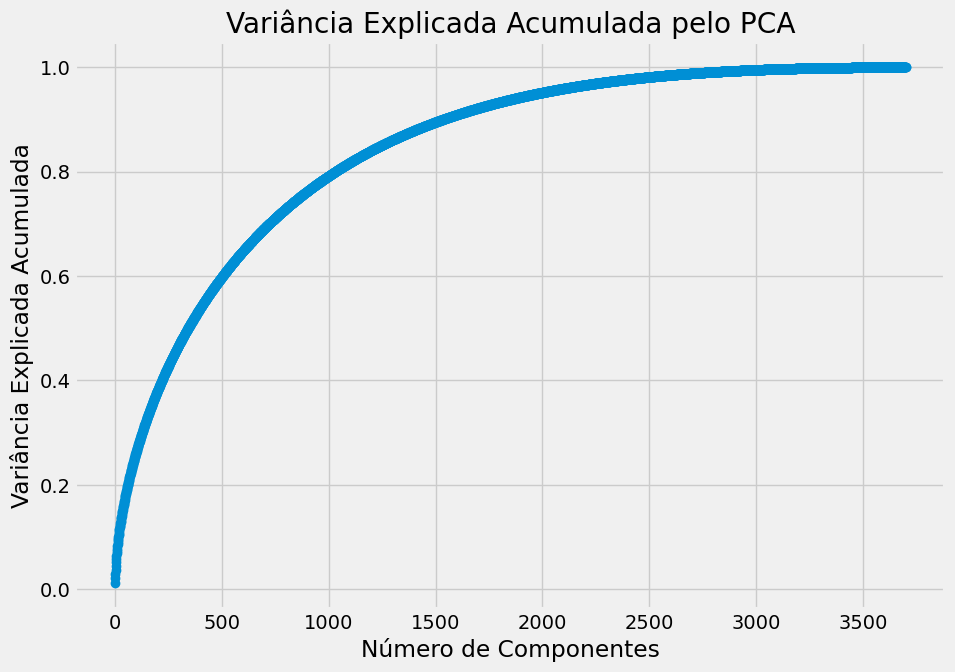

In [112]:
plt.figure(figsize=(10, 7))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.grid(True)
plt.show()

In [113]:
num_components = np.argmax(explained_variance >= 0.8) + 1
print(f"Número de componentes para manter 80% de variância: {num_components}")

Número de componentes para manter 80% de variância: 1032


Usaremos o PCA em 20 componentes e o SVD em 80% da variância dos dados

In [114]:
pca = PCA(n_components=20)
X_pca_reduced = pca.fit_transform(ratings_matrix_normalized)

print("Formato da matriz reduzida:", X_pca_reduced.shape)

Formato da matriz reduzida: (3702, 20)


In [115]:
pca = PCA(n_components=num_components)
X_pca_reduced_80 = pca.fit_transform(ratings_matrix_normalized)

In [116]:
svd = TruncatedSVD(n_components=ratings_matrix_normalized.shape[1] - 1)
X_svd = svd.fit_transform(ratings_matrix_normalized)

In [117]:
explained_variance = np.cumsum(svd.explained_variance_ratio_)

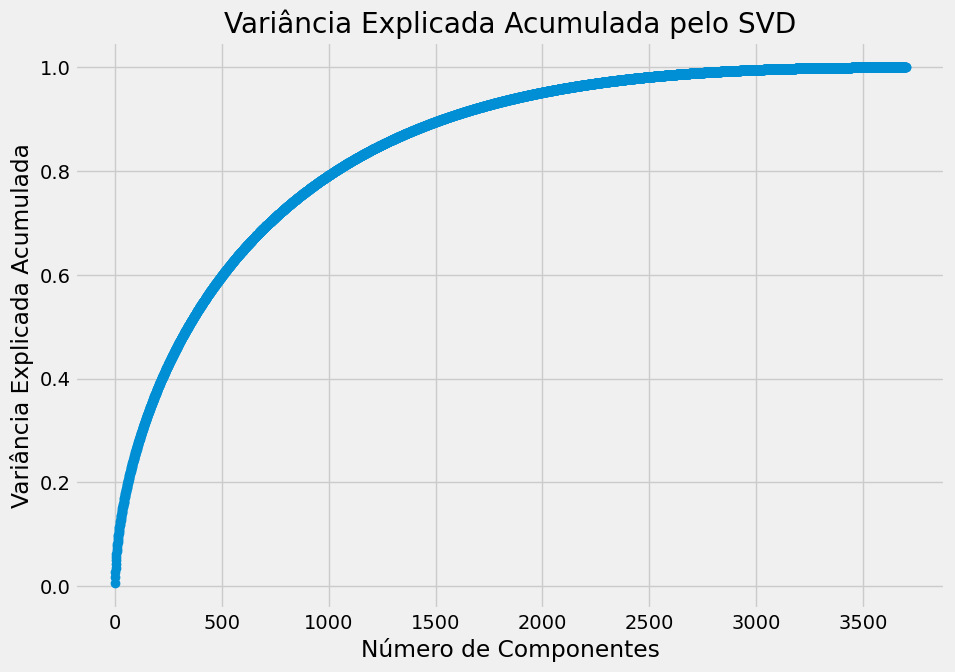

In [118]:
plt.figure(figsize=(10, 7))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada pelo SVD')
plt.grid(True)
plt.show()

In [119]:
num_components = np.argmax(explained_variance >= 0.8) + 1
print(f"Número de componentes para manter 80% de variância: {num_components}")

Número de componentes para manter 80% de variância: 1032


In [120]:
svd = TruncatedSVD(n_components=num_components)
X_svd_reduced = svd.fit_transform(ratings_matrix_normalized)

In [121]:
print("Formato da matriz reduzida:", X_svd_reduced.shape)

Formato da matriz reduzida: (3702, 1032)


Printando a diagonal principal da matriz de decomposição:

In [73]:
U, Sigma, VT = np.linalg.svd(ratings_matrix_normalized, full_matrices=False)

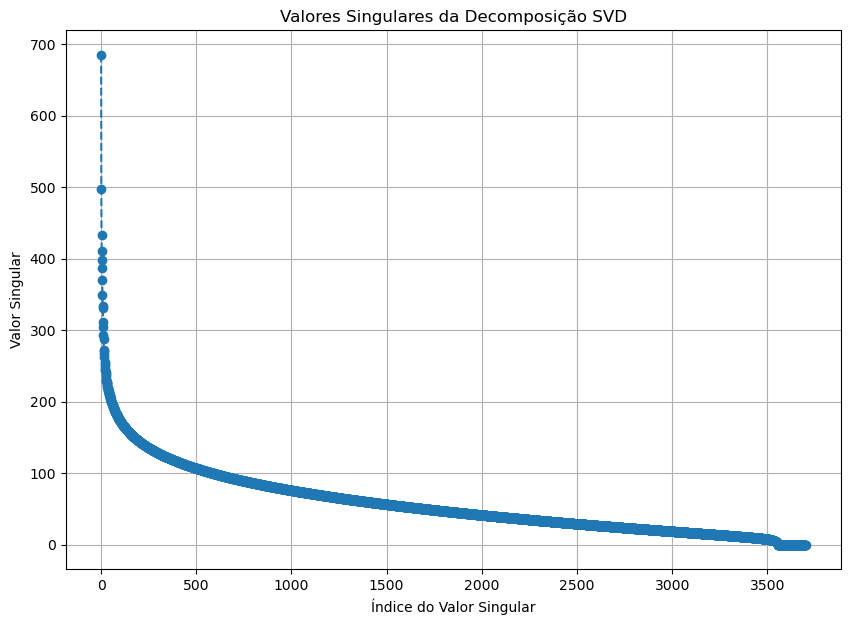

In [74]:
plt.figure(figsize=(10, 7))
plt.plot(Sigma, marker='o', linestyle='--')
plt.xlabel('Índice do Valor Singular')
plt.ylabel('Valor Singular')
plt.title('Valores Singulares da Decomposição SVD')
plt.grid(True)
plt.show()

Esse gráfico dialoga bem com a variância explicada, Até mais ou menos 1000 valores conseguimos segurar uma boa quantidade de informação dos dados

# DBSCAN Reduzido

In [122]:
cluster_genero_predominante_DBSCAN_SVD ={}
cluster_genero_predominante_DBSCAN_PCA ={}

In [123]:
k = 40  
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca_reduced)
distances, indices = nbrs.kneighbors(X_pca_reduced)

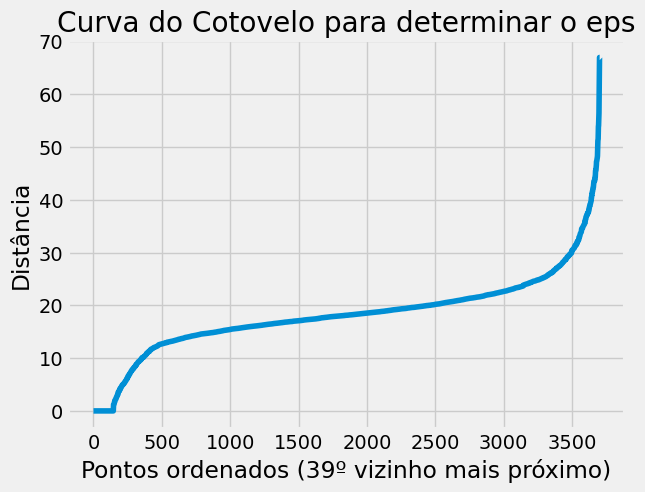

In [125]:
k_distances = np.sort(distances[:, k-1], axis=0)
plt.plot(k_distances)
plt.xlabel("Pontos ordenados (39º vizinho mais próximo)")
plt.ylabel("Distância")
plt.title("Curva do Cotovelo para determinar o eps")
plt.show()


O gráfico fornece que um vbalor entre 20 e 30 para o eps seria razoável, mas por teste, os melhores parâmetros obtidos foram os seguintes:

In [126]:
eps = 13
min_samples = 4

In [127]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_clusters = dbscan.fit_predict(X_pca_reduced)

In [128]:
movies_in_ratings['DBSCAN_Cluster_PCA'] = dbscan_clusters

In [129]:
cluster_counts = movies_in_ratings['DBSCAN_Cluster_PCA'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts) 

Contagem dos clusters formados:
 DBSCAN_Cluster_PCA
 0     2145
-1     1498
 6       13
 2        8
 1        6
 10       6
 4        6
 3        5
 8        5
 5        4
 7        4
 9        2
Name: count, dtype: int64


In [130]:
for cluster in movies_in_ratings['DBSCAN_Cluster_PCA'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['DBSCAN_Cluster_PCA'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}

    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    

    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  
    

    cluster_genero_predominante_DBSCAN_PCA[cluster] = (genero_predominante, porcentagem)

In [131]:
print(cluster_genero_predominante_DBSCAN_PCA)

{0: ('Drama', 42.09790209790209), -1: ('Drama', 38.11748998664887), 5: ('Action', 75.0), 1: ('Drama', 100.0), 2: ('Comedy', 87.5), 10: ('Action', 66.66666666666666), 4: ('Romance', 66.66666666666666), 3: ('Drama', 80.0), 7: ('Comedy', 100.0), 8: ('Horror', 100.0), 6: ('Horror', 100.0), 9: ('Drama', 100.0)}


Os clusters até apresentam um grau de coerência alto, mas pelo seu tamanho, não tem tanta significância estatística

In [133]:
composicao_media_DBPCA = 0
for key in cluster_genero_predominante_DBSCAN_PCA:
    composicao_media_DBPCA += cluster_genero_predominante_DBSCAN_PCA[key][1]
composicao_media_DBPCA = composicao_media_DBPCA/len(cluster_genero_predominante_DBSCAN_PCA)
composicao_media_DBPCA

79.67072711815702

In [134]:
print_films_in_clusters(movies_in_ratings, 'DBSCAN_Cluster_PCA')


Rocky Films:
Rocky (1976): Cluster 0
Rocky II (1979): Cluster -1
Rocky III (1982): Cluster -1
Rocky IV (1985): Cluster -1
Rocky V (1990): Cluster -1

Karate Kid:
Karate Kid, The (1984): Cluster -1
Karate Kid, Part II, The (1986): Cluster -1
Karate Kid III, The (1989): Cluster -1

Superman Films:
Superman (1978): Cluster 0
Superman II (1980): Cluster 0
Superman III (1983): Cluster -1
Superman IV: The Quest for Peace (1987): Cluster -1

Batman Films:
Batman Forever (1995): Cluster -1
Batman (1989): Cluster -1
Batman Returns (1992): Cluster -1
Batman & Robin (1997): Cluster -1

Godfather Films:
Godfather: Part III, The (1990): Cluster 0
Godfather: Part II, The (1974): Cluster 0
Godfather, The (1972): Cluster 0

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster -1
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 0
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 0
Star Wars: Episode IV - A New Hope (1977): Cluster 0

Star Trek Films:
Star T

Como podemos ver, as franquias de interesse ou ficaram no cluster monolítico  ou foram marcados como ruído.

In [135]:
k = 1000  
nbrs = NearestNeighbors(n_neighbors=k).fit(X_svd_reduced)
distances, indices = nbrs.kneighbors(X_svd_reduced)

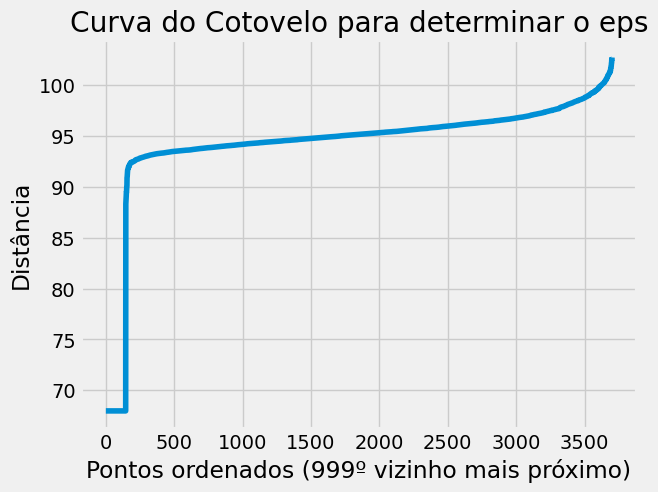

In [138]:
k_distances = np.sort(distances[:, k-1], axis=0)
plt.plot(k_distances)
plt.xlabel("Pontos ordenados (999º vizinho mais próximo)")
plt.ylabel("Distância")
plt.title("Curva do Cotovelo para determinar o eps")
plt.show()

In [137]:
k_distances = np.sort(distances[:, k-1], axis=0)

Novamnete, o melhor parâmetro observado difere do valor obtido na curva.

In [139]:
eps = 70
min_samples = 3

In [140]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_clusters = dbscan.fit_predict(X_svd_reduced)

In [141]:
movies_in_ratings['DBSCAN_Cluster_SVD'] = dbscan_clusters

In [142]:
cluster_counts = movies_in_ratings['DBSCAN_Cluster_SVD'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts) 

Contagem dos clusters formados:
 DBSCAN_Cluster_SVD
 0    2712
-1     957
 2       6
 5       5
 8       4
 3       3
 1       3
 4       3
 7       3
 6       3
 9       3
Name: count, dtype: int64


In [146]:
for cluster in movies_in_ratings['DBSCAN_Cluster_SVD'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['DBSCAN_Cluster_SVD'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}

    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    

    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  
    

    cluster_genero_predominante_DBSCAN_SVD[cluster] = (genero_predominante, porcentagem)

In [147]:
print(cluster_genero_predominante_DBSCAN_SVD)

{0: ('Drama', 39.74926253687316), -1: ('Drama', 41.692789968652036), 5: ('Comedy', 100.0), 1: ('Drama', 100.0), 2: ('Action', 33.33333333333333), 10: ('Action', 66.66666666666666), 4: ('Thriller', 66.66666666666666), 3: ('Action', 100.0), 7: ('Drama', 66.66666666666666), 8: ('Action', 100.0), 6: ('Horror', 66.66666666666666), 9: ('Horror', 100.0)}


In [148]:
composicao_media_DBSVD = 0
for key in cluster_genero_predominante_DBSCAN_SVD:
    composicao_media_DBSVD += cluster_genero_predominante_DBSCAN_SVD[key][1]
composicao_media_DBSVD = composicao_media_DBSVD/len(cluster_genero_predominante_DBSCAN_SVD)
composicao_media_DBSVD

73.45350437546043

In [149]:
print_films_in_clusters(movies_in_ratings, 'DBSCAN_Cluster_SVD')


Rocky Films:
Rocky (1976): Cluster 0
Rocky II (1979): Cluster 0
Rocky III (1982): Cluster 0
Rocky IV (1985): Cluster 0
Rocky V (1990): Cluster 0

Karate Kid:
Karate Kid, The (1984): Cluster 0
Karate Kid, Part II, The (1986): Cluster 0
Karate Kid III, The (1989): Cluster 0

Superman Films:
Superman (1978): Cluster 0
Superman II (1980): Cluster 0
Superman III (1983): Cluster 0
Superman IV: The Quest for Peace (1987): Cluster 0

Batman Films:
Batman Forever (1995): Cluster 0
Batman (1989): Cluster 0
Batman Returns (1992): Cluster 0
Batman & Robin (1997): Cluster 0

Godfather Films:
Godfather: Part III, The (1990): Cluster 0
Godfather: Part II, The (1974): Cluster 0
Godfather, The (1972): Cluster 0

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 0
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 0
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 0
Star Wars: Episode IV - A New Hope (1977): Cluster 0

Star Trek Films:
Star Trek: First Con

O mesmo problema, tivemos bons resultados mas os clusters são muito pequenos. E mesmo alterando diversos parâmetros, não consegui quebrar esse primeiro grande cluster. E dessa vez tivemos menos filmes marcados como ruído

# KMeans Reduzido

In [150]:
cluster_genero_predominante_kmeans_PCA = {}
cluster_genero_predominante_kmeans_SVD = {}

In [151]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42}

In [153]:
sse = []
for k in range(1, 81):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs, )
   kmeans.fit(X_pca_reduced)
   sse.append(kmeans.inertia_)

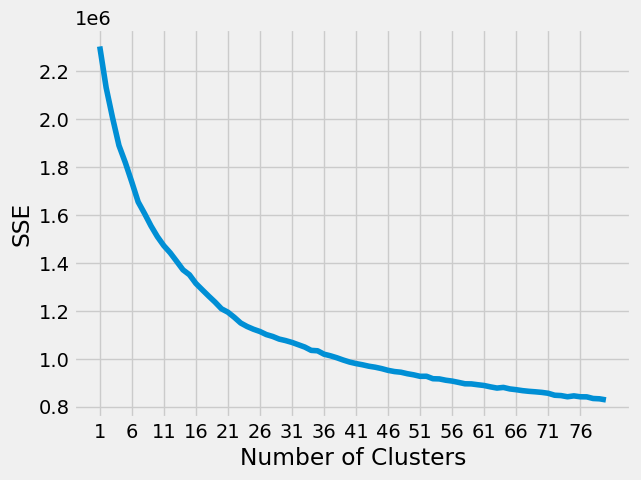

In [154]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 81), sse)
plt.xticks(range(1, 81, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [155]:
kl = KneeLocator(range(1, 81), sse, curve="convex", direction="decreasing")

In [156]:
kl.elbow

23

Usei um valor próximo ao recomendado, pelo mesmo motivo.

In [157]:
kmeans = KMeans(n_clusters=24, random_state=42, n_init = 10)
kmeans_clusters = kmeans.fit_predict(X_pca_reduced)

In [158]:
movies_in_ratings['KMeans_Cluster_PCA'] = kmeans_clusters

In [159]:
cluster_counts = movies_in_ratings['KMeans_Cluster_PCA'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 KMeans_Cluster_PCA
1     675
11    312
15    283
0     277
2     239
21    220
18    199
20    171
12    170
16    129
6     125
8     116
19    115
5     108
22     97
10     91
7      90
9      86
4      55
23     42
14     32
3      31
17     24
13     15
Name: count, dtype: int64


In [160]:
cluster_genero_predominante_kmeans_PCA = {}
for cluster in movies_in_ratings['KMeans_Cluster_PCA'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['KMeans_Cluster_PCA'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None 
    
    cluster_genero_predominante_kmeans_PCA[cluster] = (genero_predominante, porcentagem)

In [161]:
print(cluster_genero_predominante_kmeans_PCA)

{20: ("Children's", 83.04093567251462), 18: ('Comedy', 92.46231155778895), 0: ('Drama', 62.093862815884485), 2: ('Action', 80.3347280334728), 11: ('Drama', 45.51282051282051), 15: ('Drama', 74.20494699646643), 4: ('Drama', 50.90909090909091), 16: ('Drama', 58.91472868217055), 1: ('Drama', 44.0), 8: ('Drama', 31.03448275862069), 19: ('Romance', 49.56521739130435), 5: ('Drama', 98.14814814814815), 22: ('Drama', 56.70103092783505), 6: ('Horror', 97.6), 17: ('Drama', 95.83333333333334), 7: ('Drama', 55.55555555555556), 10: ('Horror', 79.12087912087912), 21: ('Action', 49.09090909090909), 13: ('Drama', 86.66666666666667), 9: ('Comedy', 41.86046511627907), 12: ('Drama', 34.705882352941174), 14: ('Drama', 31.25), 23: ('Comedy', 30.952380952380953), 3: ('Drama', 38.70967741935484)}


In [162]:
composicao_media_KPCA = 0
for key in cluster_genero_predominante_kmeans_PCA:
    composicao_media_KPCA += cluster_genero_predominante_kmeans_PCA[key][1]
composicao_media_KPCA = composicao_media_KPCA/len(cluster_genero_predominante_kmeans_PCA)
composicao_media_KPCA

61.17783558393407

In [163]:
print_films_in_clusters(movies_in_ratings, 'KMeans_Cluster_PCA')


Rocky Films:
Rocky (1976): Cluster 21
Rocky II (1979): Cluster 21
Rocky III (1982): Cluster 21
Rocky IV (1985): Cluster 18
Rocky V (1990): Cluster 2

Karate Kid:
Karate Kid, The (1984): Cluster 0
Karate Kid, Part II, The (1986): Cluster 18
Karate Kid III, The (1989): Cluster 18

Superman Films:
Superman (1978): Cluster 21
Superman II (1980): Cluster 21
Superman III (1983): Cluster 2
Superman IV: The Quest for Peace (1987): Cluster 2

Batman Films:
Batman Forever (1995): Cluster 2
Batman (1989): Cluster 21
Batman Returns (1992): Cluster 2
Batman & Robin (1997): Cluster 2

Godfather Films:
Godfather: Part III, The (1990): Cluster 0
Godfather: Part II, The (1974): Cluster 11
Godfather, The (1972): Cluster 11

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 2
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 21
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 21
Star Wars: Episode IV - A New Hope (1977): Cluster 21

Star Trek Films:
Star T

Resultado muito próximo ao sem PCA

In [164]:
sse = []
for k in range(1, 81):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs, )
   kmeans.fit(X_svd_reduced)
   sse.append(kmeans.inertia_)

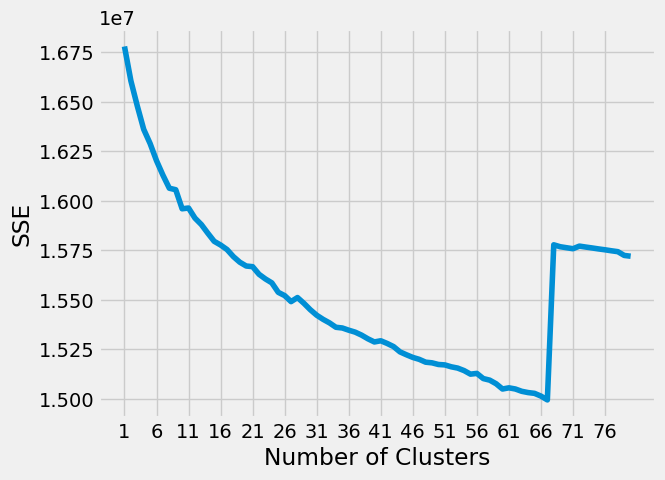

In [165]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 81), sse)
plt.xticks(range(1, 81, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [166]:
kl.elbow

23

In [173]:
kmeans = KMeans(n_clusters=24, random_state=42, n_init = 10)
kmeans_clusters = kmeans.fit_predict(X_svd_reduced)

In [174]:
movies_in_ratings['KMeans_Cluster_SVD'] = kmeans_clusters

In [176]:
cluster_counts = movies_in_ratings['KMeans_Cluster_SVD'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 KMeans_Cluster_SVD
9     611
16    236
7     223
13    212
5     210
11    207
14    192
8     190
17    169
15    151
2     142
18    139
12    123
1     113
3     112
6     109
10    104
21    104
4      85
23     78
0      70
19     49
22     39
20     34
Name: count, dtype: int64


In [171]:
for cluster in movies_in_ratings['KMeans_Cluster_SVD'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['KMeans_Cluster_SVD'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    

    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None
    
    cluster_genero_predominante_kmeans_SVD[cluster] = (genero_predominante, porcentagem)

In [172]:
print(cluster_genero_predominante_kmeans_SVD)

{2: ("Children's", 95.07042253521126), 3: ('Comedy', 51.78571428571429), 14: ('Drama', 63.020833333333336), 7: ('Comedy', 48.4304932735426), 16: ('Drama', 53.38983050847458), 13: ('Action', 82.54716981132076), 11: ('Comedy', 42.028985507246375), 1: ('Comedy', 96.46017699115043), 0: ('Drama', 51.42857142857142), 9: ('Drama', 45.99018003273322), 19: ('Drama', 85.71428571428571), 10: ('Romance', 52.88461538461539), 8: ('Drama', 53.1578947368421), 15: ('Drama', 52.317880794701985), 12: ('Drama', 97.5609756097561), 22: ('Comedy', 53.84615384615385), 17: ('Horror', 93.49112426035504), 4: ('Drama', 51.76470588235295), 23: ('Horror', 83.33333333333334), 5: ('Drama', 73.33333333333333), 6: ('Drama', 30.275229357798167), 20: ('Comedy', 64.70588235294117), 21: ('Drama', 38.46153846153847), 18: ('Action', 42.44604316546763)}


In [177]:
composicao_media_KSVD = 0
for key in cluster_genero_predominante_kmeans_SVD:
    composicao_media_KSVD += cluster_genero_predominante_kmeans_SVD[key][1]
composicao_media_KSVD = composicao_media_KSVD/len(cluster_genero_predominante_kmeans_SVD)
composicao_media_KSVD

62.643557247532236

In [178]:
print_films_in_clusters(movies_in_ratings, 'KMeans_Cluster_SVD')


Rocky Films:
Rocky (1976): Cluster 11
Rocky II (1979): Cluster 11
Rocky III (1982): Cluster 11
Rocky IV (1985): Cluster 11
Rocky V (1990): Cluster 13

Karate Kid:
Karate Kid, The (1984): Cluster 11
Karate Kid, Part II, The (1986): Cluster 11
Karate Kid III, The (1989): Cluster 13

Superman Films:
Superman (1978): Cluster 11
Superman II (1980): Cluster 11
Superman III (1983): Cluster 13
Superman IV: The Quest for Peace (1987): Cluster 13

Batman Films:
Batman Forever (1995): Cluster 13
Batman (1989): Cluster 11
Batman Returns (1992): Cluster 11
Batman & Robin (1997): Cluster 13

Godfather Films:
Godfather: Part III, The (1990): Cluster 13
Godfather: Part II, The (1974): Cluster 16
Godfather, The (1972): Cluster 16

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 11
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 11
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 11
Star Wars: Episode IV - A New Hope (1977): Cluster 11

Star Trek Film

Conseguimos encontrar todos os filmes de star wars e quase todos de star trek em um mesmo cluster, o que mostra uma evolução frente aos anteriores

Verificaremos o PCA com a mesma dimensionalidade

In [182]:
kmeans = KMeans(n_clusters=23, random_state=42, n_init = 10)
kmeans_clusters = kmeans.fit_predict(X_pca_reduced_80)

In [183]:
movies_in_ratings['KMeans_Cluster_PCA80)'] = kmeans_clusters

In [184]:
cluster_counts = movies_in_ratings['KMeans_Cluster_PCA80)'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 KMeans_Cluster_PCA80)
6     654
4     419
16    285
8     228
10    220
13    152
15    145
22    143
19    141
5     126
9     125
14    110
21    107
2     106
12    101
3      94
18     93
20     93
1      90
7      85
11     70
0      67
17     48
Name: count, dtype: int64


In [185]:
for cluster in movies_in_ratings['KMeans_Cluster_PCA80)'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['KMeans_Cluster_PCA80)'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None
    
    cluster_genero_predominante_kmeans_PCA[cluster] = (genero_predominante, porcentagem)

In [186]:
print(cluster_genero_predominante_kmeans_PCA)

{20: ('Sci-Fi', 80.64516129032258), 18: ('Comedy', 40.86021505376344), 0: ('Drama', 61.19402985074627), 2: ('Romance', 56.60377358490566), 11: ('Drama', 51.42857142857142), 15: ('Drama', 97.93103448275862), 4: ('Drama', 58.47255369928401), 16: ('Drama', 71.2280701754386), 1: ('Drama', 50.0), 8: ('Action', 66.66666666666666), 19: ('Drama', 38.297872340425535), 5: ('Drama', 54.761904761904766), 22: ('Comedy', 73.42657342657343), 6: ('Drama', 47.40061162079511), 17: ('Horror', 45.83333333333333), 7: ('Comedy', 70.58823529411765), 10: ('Comedy', 69.54545454545455), 21: ('Comedy', 53.271028037383175), 13: ('Comedy', 79.60526315789474), 9: ('Horror', 95.19999999999999), 12: ('Action', 44.554455445544555), 14: ("Children's", 94.54545454545455), 23: ('Comedy', 30.952380952380953), 3: ('Horror', 82.97872340425532)}


Tivemos um bom cluster do Horror também

In [191]:
cluster_20_movies = movies_in_ratings[movies_in_ratings['KMeans_Cluster_PCA80)'] == 20]

In [192]:
print("Títulos dos filmes no cluster 20:")
for title in cluster_20_movies['Title']:
    print(title)

Títulos dos filmes no cluster 20:
Star Wars: Episode IV - A New Hope (1977)
Star Trek: Generations (1994)
Jurassic Park (1993)
Terminator 2: Judgment Day (1991)
Batman (1989)
Heavy Metal (1981)
Arrival, The (1996)
20,000 Leagues Under the Sea (1954)
E.T. the Extra-Terrestrial (1982)
Top Gun (1986)
Abyss, The (1989)
Star Wars: Episode V - The Empire Strikes Back (1980)
Raiders of the Lost Ark (1981)
Transformers: The Movie, The (1986)
Star Wars: Episode VI - Return of the Jedi (1983)
Terminator, The (1984)
Day the Earth Stood Still, The (1951)
Back to the Future (1985)
Highlander (1986)
Indiana Jones and the Last Crusade (1989)
Forbidden Planet (1956)
Star Trek: First Contact (1996)
Star Trek: The Motion Picture (1979)
Star Trek VI: The Undiscovered Country (1991)
Star Trek V: The Final Frontier (1989)
Star Trek: The Wrath of Khan (1982)
Star Trek III: The Search for Spock (1984)
Star Trek IV: The Voyage Home (1986)
Sneakers (1992)
Fifth Element, The (1997)
Men in Black (1997)
Contact (

Foi possível encontrar um cluster com os filmes de Star Trek, além de um filme Star Wars e Duna, e filmes da trilogia original do planeta dos macacos.

In [189]:
print_films_in_clusters(movies_in_ratings, 'KMeans_Cluster_PCA80)')


Rocky Films:
Rocky (1976): Cluster 13
Rocky II (1979): Cluster 21
Rocky III (1982): Cluster 21
Rocky IV (1985): Cluster 21
Rocky V (1990): Cluster 21

Karate Kid:
Karate Kid, The (1984): Cluster 21
Karate Kid, Part II, The (1986): Cluster 21
Karate Kid III, The (1989): Cluster 21

Superman Films:
Superman (1978): Cluster 20
Superman II (1980): Cluster 20
Superman III (1983): Cluster 21
Superman IV: The Quest for Peace (1987): Cluster 21

Batman Films:
Batman Forever (1995): Cluster 8
Batman (1989): Cluster 20
Batman Returns (1992): Cluster 8
Batman & Robin (1997): Cluster 8

Godfather Films:
Godfather: Part III, The (1990): Cluster 8
Godfather: Part II, The (1974): Cluster 12
Godfather, The (1972): Cluster 12

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 20
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 20
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 20
Star Wars: Episode IV - A New Hope (1977): Cluster 20

Star Trek Films:
S

Como podemos ver, todos os filmes de star wars e star trek no mesmo cluster, bem como todos os 3 filmes de karate kid no mesmo cluster, junto com a maioria dos filmes de Rocky, o que é muito bom dada a temática de luta.

In [193]:
composicao_media_KPCA = 0
for key in cluster_genero_predominante_kmeans_PCA:
    composicao_media_KPCA += cluster_genero_predominante_kmeans_PCA[key][1]
composicao_media_KPCA = composicao_media_KPCA/len(cluster_genero_predominante_kmeans_PCA)
composicao_media_KPCA

63.166306962415625

# Cluster Hierárquico Reduzido

Como na primeira tentativa os clusters ficaram pouco coesos, tentei aumentar a quantidade de clusters para separar melhor

In [214]:
agg_clustering = AgglomerativeClustering(n_clusters=60, linkage='complete')
agg_clusters = agg_clustering.fit_predict(X_pca_reduced)

In [215]:
cluster_genero_predominante_hie_SVD = {}
cluster_genero_predominante_hie_PCA = {}

In [216]:
movies_in_ratings['Hierarchical_Cluster_PCA'] = agg_clusters

In [217]:
cluster_counts = movies_in_ratings['Hierarchical_Cluster_PCA'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 Hierarchical_Cluster_PCA
7     974
13    593
26    389
9     237
11    236
18    150
6      70
1      67
0      65
55     65
24     62
58     61
34     60
10     57
5      55
50     52
14     37
4      34
8      32
23     28
29     27
20     27
12     23
30     23
21     22
16     22
42     21
19     20
54     16
52     14
25     14
32     11
35     11
3       9
44      9
57      9
51      8
48      7
17      7
2       7
45      7
41      7
15      6
40      6
28      6
36      5
22      5
27      4
31      3
33      3
59      3
56      2
43      2
46      2
38      2
49      2
53      2
37      2
47      1
39      1
Name: count, dtype: int64


In [222]:
for cluster in movies_in_ratings['Hierarchical_Cluster_PCA'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['Hierarchical_Cluster_PCA'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    total_filmes_no_cluster = len(cluster_df)
    if total_filmes_no_cluster < 10:
        continue
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None 

    cluster_genero_predominante_hie_PCA[cluster] = (genero_predominante, porcentagem)

In [221]:
print(cluster_genero_predominante_hie_PCA)

{11: ("Children's", 48.30508474576271), 26: ('Comedy', 50.128534704370175), 1: ('Drama', 34.32835820895522), 9: ('Action', 60.337552742616026), 5: ('Comedy', 87.27272727272727), 7: ('Drama', 58.31622176591375), 13: ('Comedy', 37.60539629005059), 24: ('Drama', 66.12903225806451), 50: ('Romance', 55.769230769230774), 14: ('Drama', 94.5945945945946), 6: ('Drama', 94.28571428571428), 25: ('Drama', 100.0), 23: ('Comedy', 92.85714285714286), 12: ('Drama', 60.86956521739131), 19: ('Drama', 85.0), 0: ('Drama', 58.46153846153847), 10: ('Horror', 28.07017543859649), 8: ('Drama', 56.25), 20: ('Drama', 40.74074074074074), 55: ('Horror', 81.53846153846153), 34: ('Horror', 98.33333333333333), 29: ('Drama', 29.629629629629626), 18: ('Drama', 38.0), 52: ('Horror', 42.857142857142854), 16: ('Action', 68.18181818181817), 58: ('Horror', 100.0), 35: ('Drama', 100.0), 30: ('Drama', 56.52173913043478), 4: ('Comedy', 38.23529411764706), 21: ('Musical', 27.27272727272727), 42: ('Drama', 38.095238095238095), 3

Em um primeiro momento foi verificado uma baixa coerência interna, o número de clusters foi aumentado para 60 e foram filtrados aqueles com menos de 10 filmes

In [223]:
composicao_media_HPCA = 0
for key in cluster_genero_predominante_hie_PCA:
    composicao_media_HPCA += cluster_genero_predominante_hie_PCA[key][1]
composicao_media_HPCA = composicao_media_HPCA/len(cluster_genero_predominante_hie_PCA)
composicao_media_HPCA

62.55607972343875

In [224]:
print_films_in_clusters(movies_in_ratings, 'Hierarchical_Cluster_PCA')


Rocky Films:
Rocky (1976): Cluster 26
Rocky II (1979): Cluster 26
Rocky III (1982): Cluster 26
Rocky IV (1985): Cluster 26
Rocky V (1990): Cluster 9

Karate Kid:
Karate Kid, The (1984): Cluster 26
Karate Kid, Part II, The (1986): Cluster 9
Karate Kid III, The (1989): Cluster 9

Superman Films:
Superman (1978): Cluster 26
Superman II (1980): Cluster 26
Superman III (1983): Cluster 9
Superman IV: The Quest for Peace (1987): Cluster 9

Batman Films:
Batman Forever (1995): Cluster 26
Batman (1989): Cluster 26
Batman Returns (1992): Cluster 13
Batman & Robin (1997): Cluster 9

Godfather Films:
Godfather: Part III, The (1990): Cluster 26
Godfather: Part II, The (1974): Cluster 7
Godfather, The (1972): Cluster 7

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 26
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 26
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 26
Star Wars: Episode IV - A New Hope (1977): Cluster 26

Star Trek Films:
Star 

Também conseguimos juntar star wars e star trek no mesmo cluster, mas ele é um cluster maior e mais generalizado, portanto o resultado do KMeans ainda foi melhor

In [225]:
agg_clustering = AgglomerativeClustering(n_clusters=60, linkage='complete')
agg_clusters = agg_clustering.fit_predict(X_svd_reduced)

In [226]:
movies_in_ratings['Hierarchical_Cluster_SVD'] = agg_clusters

In [227]:
cluster_counts = movies_in_ratings['Hierarchical_Cluster_SVD'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 Hierarchical_Cluster_SVD
19    347
29    294
8     256
6     225
59    168
44    167
54    151
24    114
36    106
7     103
9      89
26     88
0      83
2      81
31     77
35     72
4      72
1      67
18     61
43     61
17     59
11     54
37     52
10     48
28     46
20     45
49     43
21     43
15     42
27     40
53     38
32     38
3      35
16     34
48     34
5      29
34     28
22     28
12     27
14     26
46     26
13     25
40     19
38     18
58     18
45     16
50     13
56     13
30     12
25     10
42     10
55      9
23      8
51      8
33      7
39      5
41      4
52      4
47      3
57      3
Name: count, dtype: int64


In [229]:
for cluster in movies_in_ratings['Hierarchical_Cluster_SVD'].unique():
    cluster_df = movies_in_ratings[movies_in_ratings['Hierarchical_Cluster_SVD'] == cluster]
    
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    total_filmes_no_cluster = len(cluster_df)
    if total_filmes_no_cluster < 10:
        continue
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  
    cluster_genero_predominante_hie_SVD[cluster] = (genero_predominante, porcentagem)

In [230]:
print(cluster_genero_predominante_hie_SVD)

{7: ("Children's", 63.10679611650486), 19: ('Comedy', 42.07492795389049), 2: ('Comedy', 45.67901234567901), 0: ('Comedy', 66.26506024096386), 54: ('Drama', 57.615894039735096), 44: ('Action', 46.706586826347305), 43: ('Drama', 59.01639344262295), 12: ('Drama', 55.55555555555556), 29: ('Comedy', 40.136054421768705), 14: ('Drama', 53.84615384615385), 6: ('Drama', 54.666666666666664), 18: ('Drama', 40.98360655737705), 3: ('Thriller', 28.57142857142857), 24: ('Drama', 47.368421052631575), 4: ('Drama', 63.888888888888886), 8: ('Comedy', 31.25), 46: ('Drama', 61.53846153846154), 21: ('Comedy', 60.46511627906976), 48: ('Romance', 61.76470588235294), 26: ('Horror', 43.18181818181818), 1: ('Drama', 67.16417910447761), 9: ('Comedy', 38.20224719101123), 20: ('Drama', 57.77777777777777), 37: ('Drama', 98.07692307692307), 58: ('Drama', 77.77777777777779), 56: ('Drama', 92.3076923076923), 53: ('Drama', 63.1578947368421), 35: ('Comedy', 48.61111111111111), 30: ('Comedy', 41.66666666666667), 32: ('Dra

In [231]:
composicao_media_HSVD = 0
for key in cluster_genero_predominante_hie_SVD:
    composicao_media_HSVD += cluster_genero_predominante_hie_SVD[key][1]
composicao_media_HSVD = composicao_media_HSVD/len(cluster_genero_predominante_hie_SVD)
composicao_media_HSVD

56.48258926479682

In [233]:
print_films_in_clusters(movies_in_ratings, 'Hierarchical_Cluster_SVD')


Rocky Films:
Rocky (1976): Cluster 44
Rocky II (1979): Cluster 44
Rocky III (1982): Cluster 44
Rocky IV (1985): Cluster 44
Rocky V (1990): Cluster 19

Karate Kid:
Karate Kid, The (1984): Cluster 19
Karate Kid, Part II, The (1986): Cluster 19
Karate Kid III, The (1989): Cluster 19

Superman Films:
Superman (1978): Cluster 19
Superman II (1980): Cluster 19
Superman III (1983): Cluster 19
Superman IV: The Quest for Peace (1987): Cluster 19

Batman Films:
Batman Forever (1995): Cluster 29
Batman (1989): Cluster 19
Batman Returns (1992): Cluster 19
Batman & Robin (1997): Cluster 29

Godfather Films:
Godfather: Part III, The (1990): Cluster 54
Godfather: Part II, The (1974): Cluster 8
Godfather, The (1972): Cluster 8

Star Wars Films:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 54
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 54
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 54
Star Wars: Episode IV - A New Hope (1977): Cluster 54

Star Trek Films:

O cluster 19 acabou sendo o maior dos clusters, e portanto aglomerou diversos filmes, alguns com pouca relação como karate kid e star trek, enquanto filmes mais correlatos como star trek e star wars acabaram em clusters diferentes. Se vale uma pontuação, tivemos uma diversidade de gêneros interessantes, tendo por exemplo um cluster de documentários.

# Resultados

Dados os 3 métodos empregados, e suas variações com e sem PCA/SVD, foi possível observar que o DBScan foi o pior método entre os observados, com e sem uso de redutores de dimensionalidade.

O Método de K-Means apresentou os melhores resultados, especialmente com o uso de PCA e mantendo 80% da variânca, onde foi possível encontrar tanto o cluster de horror quanto o cluster de Star trek e star wars, ficção científica como um todo. Vale ressaltar que o tamanho do cluster era de cerca de 100 filmes, portanto ele agregou bem filmes com temáticas semelhantes.

Já o Método de cluster hierárquico obteve resultados não muito satisfatórios na média, ele tem tendência a produzir alguns clusters maiores, dando a impressão de que ele clusterizou bem, mas na verdade diversas coisas pouco correlatas apareceram juntas.

O método que apresentou uma maior dificuldade foi o DBScan, em todos os casos, ou o cluster de rúido ficava muito grande, ou os dados se agrupavam em um grande cluster, com poucos clusters menores 